In [1]:
import lasio as las
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import LSTM, Dense
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
f = las.read("/home/duys/Downloads/ccl_data/stage2b-pass4.las")

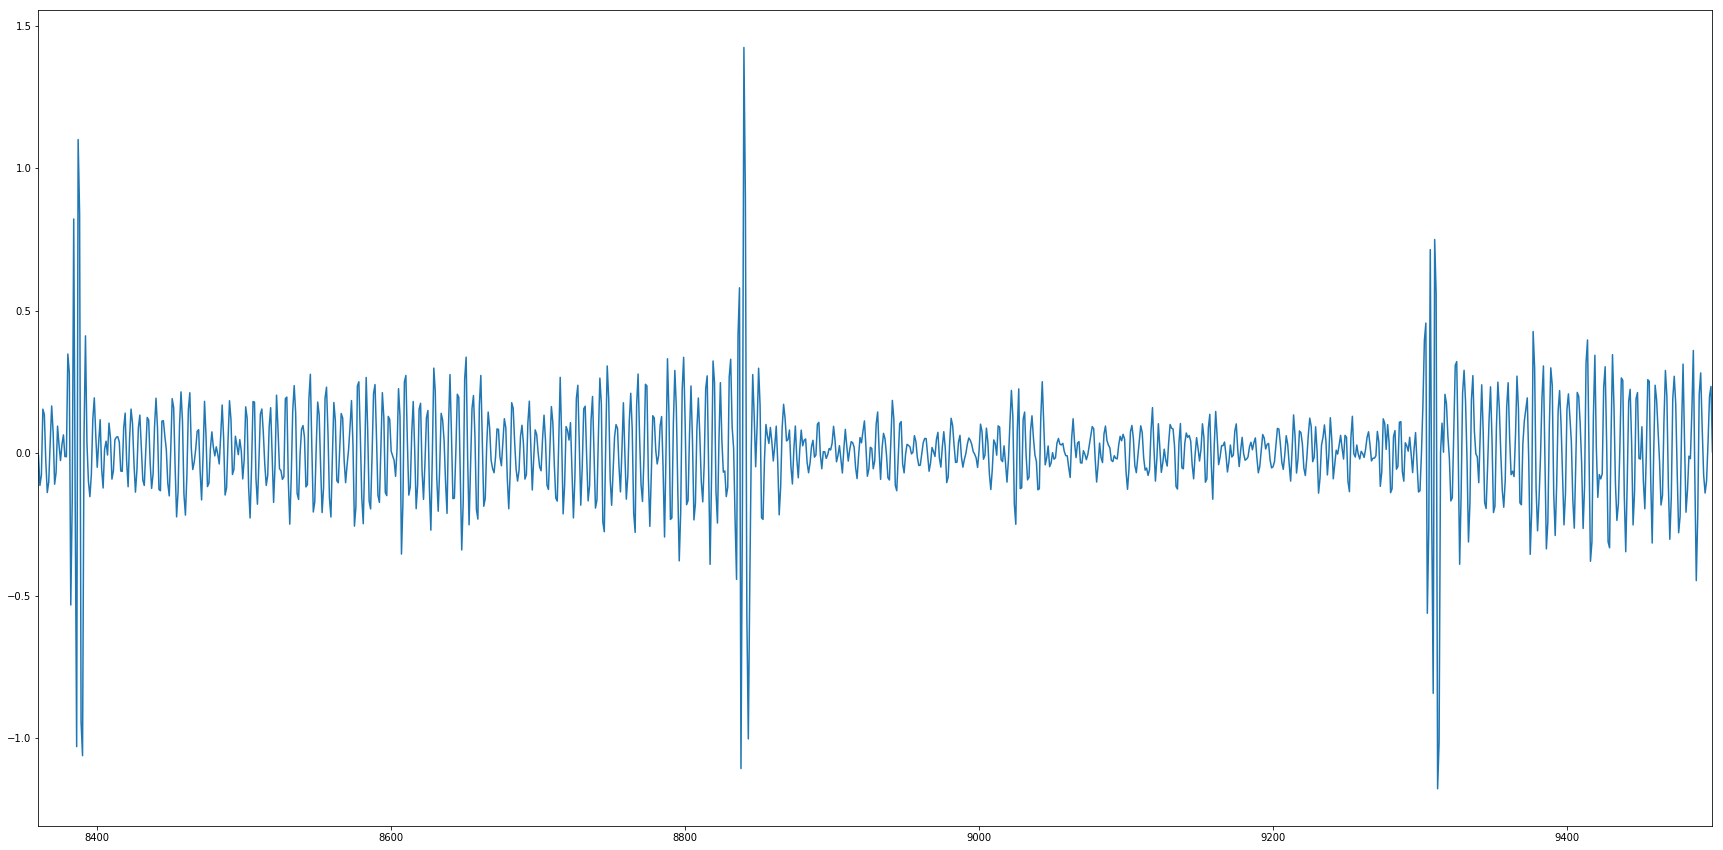

In [3]:
def show_depth(fr, to):
    df['signal'][fr:to].plot(figsize=(30,15))
data = f['CCL']
df = pd.DataFrame(data, columns=['signal'])
show_depth(8360, 9500)

In [6]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

In [7]:
cos = gen_cosine_amp()
lahead = 1
tsteps = 1
batch_size = 25
epochs = 25

In [8]:
cos[0:10]
expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

In [9]:
cos.shape, expected_output.shape

((50000, 1, 1), (50000, 1))

In [10]:
print('Creating Model...')
model = Sequential()
model.add(LSTM(50,
               input_shape=(batch_size, tsteps),
               #batch_size=batch_size,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

W0701 17:55:50.391993 140648786642752 deprecation_wrapper.py:119] From /home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:47: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 17:55:50.396025 140648786642752 deprecation_wrapper.py:119] From /home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:351: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 17:55:50.400369 140648786642752 deprecation.py:506] From /home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:521: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument in

Creating Model...


W0701 17:55:52.559943 140648786642752 deprecation_wrapper.py:119] From /home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/keras/optimizers.py:675: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (25, 1, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (25, 50)                  20200     
_________________________________________________________________
dense_1 (Dense)              (25, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [11]:
for i in range(epochs):
    model.fit(cos, expected_output,
              batch_size=batch_size,
              epochs=1,
              verbose=1,
              shuffle=False,
    )
    model.reset_states()

W0701 17:56:42.490518 140648786642752 deprecation.py:323] From /home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
50000/50000 [==============================] - 17s - loss: 354.8399    
Epoch 1/1
50000/50000 [==============================] - 11s - loss: 212.2024    
Epoch 1/1
50000/50000 [==============================] - 12s - loss: 143.7932    
Epoch 1/1
50000/50000 [==============================] - 10s - loss: 171.9236    
Epoch 1/1
50000/50000 [==============================] - 12s - loss: 97.2314    
Epoch 1/1
50000/50000 [==============================] - 12s - loss: 91.9910    
Epoch 1/1
50000/50000 [==============================] - 11s - loss: 48.1701    
Epoch 1/1
50000/50000 [==============================] - 9s - loss: 39.7473     
Epoch 1/1
50000/50000 [==============================] - 12s - loss: 32.0384    
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 31.4773    
Epoch 1/1
50000/50000 [==============================] - 12s - loss: 18.3597    
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 18.2642    
Epoch 1/1
50000/50000 [=

Predicting
Plotting Results


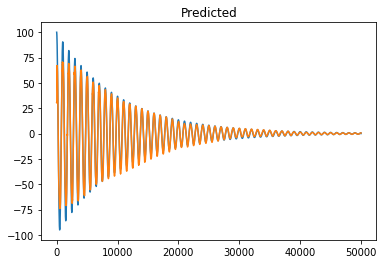

In [13]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

print('Plotting Results')
#plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
#plt.subplot(2, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()